<a href="https://colab.research.google.com/github/MithunKiniStar/AutoEncodersFaceSketch/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
import cv2 as cv

In [5]:
!pip install keras==2.1.0
# !pip install tensorflow==2.1.0

     |████████████████████████████████| 302 kB 4.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [3]:
print(tf.__version__)

2.1.0


In [6]:
import scipy
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate,concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU,ReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D,Conv2DTranspose
from tensorflow.keras import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
# from data_loader import DataLoader
import numpy as np
import os
import cv2 as cv

Using TensorFlow backend.


In [15]:
!mkdir -p dataset


In [16]:
path ='/content/dataset'

In [18]:
cd '/content/dataset'

/content/dataset


In [19]:
pwd

'/content/dataset'

In [20]:
!mkdir -p pix2pix/test/concat
!mkdir -p pix2pix/train/concat

In [21]:
_URL1 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_sketches.zip'

_URL2 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/training_88/Cropped_Images/CUHK_training_cropped_photos.zip'

_URL3 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Cropped_Images/CUHK_testing_cropped_sketches.zip'

_URL4 = 'http://mmlab.ie.cuhk.edu.hk/archive/sketchdatabase/CUHK/testing_100/Cropped_Images/CUHK_testing_cropped_photos.zip'

path_to_zip1 = tf.keras.utils.get_file(path+'/pix2pix/train/CUHK_training_cropped_sketches.zip',
                                      origin=_URL1,archive_format='zip',
                                       cache_subdir=path+'/pix2pix/train',
                                      extract=True)

path_to_zip2 = tf.keras.utils.get_file(path+'/pix2pix/train/CUHK_training_cropped_photos.zip',
                                      origin=_URL2,archive_format='zip',
                                       cache_subdir=path+'/pix2pix/train',
                                      extract=True)

path_to_zip3 = tf.keras.utils.get_file(path+'/pix2pix/test/CUHK_testing_cropped_sketches.zip',
                                       cache_subdir=path+'/pix2pix/test',
                                      origin=_URL3,
                                      extract=True)

path_to_zip4 = tf.keras.utils.get_file(path+'/pix2pix/test/CUHK_testing_cropped_photos.zip',
                                      origin=_URL4,
                                       cache_subdir=path+'/pix2pix/test',
                                      extract=True)

778240/771222 [==============================] - 0s 0us/step


In [22]:
PATH1 = os.path.join(os.path.dirname(path_to_zip1), 'sketches/')

PATH2 = os.path.join(os.path.dirname(path_to_zip2), 'photos/')

PATH3 = os.path.join(os.path.dirname(path_to_zip3), 'sketches/')

PATH4 = os.path.join(os.path.dirname(path_to_zip4), 'photos/')

**Data Preprocessing**

In [26]:
def numpyimage(sketch_image_file, original_image):
  image1 = cv.imread(sketch_image_file)
  image2 = cv.imread(original_image)
  return image1, image2

In [28]:
def load(sketch_image_file, original_image):
  # image1 = cv.imread(sketch_image_file)
  # image2 = cv.imread(original_image)
  image1 = tf.io.read_file(sketch_image_file)
  image1 = tf.image.decode_jpeg(image1,channels=3)


  image2 = tf.io.read_file(original_image)
  image2 = tf.image.decode_jpeg(image2,channels=3)

  
  image1 = tf.cast(image1, tf.float32)
  image2 = tf.cast(image2, tf.float32)

  return image1, image2

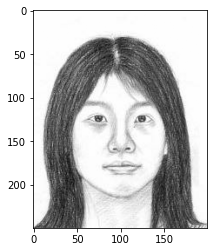

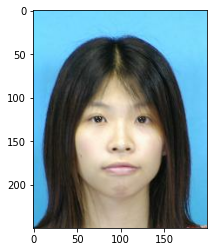

In [29]:
inp, re = load(PATH1+'F2-005-01-sz1.jpg', PATH2+'f-005-01.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [30]:
print(re.shape)

print(inp.shape)

(250, 200, 3)
(250, 200, 3)


In [31]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [32]:
def random_jitter(input_image, real_image):
  # resizing to 256 x 256 x 3
  input_image, real_image = resize(input_image, real_image, 256, 256)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [33]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

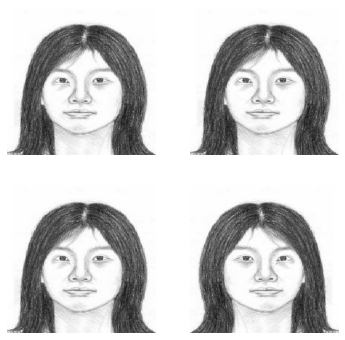

In [34]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255)
  plt.axis('off')
plt.show()

In [35]:
rj_inp.shape

TensorShape([256, 256, 3])

In [36]:
import glob
train_sketch = glob.glob(path+"/pix2pix/train/sketches/*")
train_photo = glob.glob(path+"/pix2pix/train/photos/*")

In [37]:
test_sketch = glob.glob(path+"/pix2pix/test/sketches/*")
test_photo = glob.glob(path+"/pix2pix/test/photos/*")

In [38]:
train_sketch = sorted(train_sketch)
train_photo = sorted(train_photo)

In [39]:
test_sketch = sorted(test_sketch)
test_photo = sorted(test_photo)

In [40]:
train=[]
for i in range(0,88):
  train.append(train_sketch[i]+' '+train_photo[i])

In [41]:
test=[]
for i in range(0,100):
  test.append(test_sketch[i]+' '+test_photo[i])

In [42]:
j=0
for i in train:
  im = i.split(' ')
  # print(im)
  im[0],im[1] = numpyimage(im[0], im[1])
  im_v = cv.hconcat([im[0], im[1]])
  cv.imwrite(path+'/pix2pix/train/concat/'+str(j)+'_merged.jpg', im_v)
  # plt.figure()
  # # plt.imshow(im_v/255.0)
  j = j+1

In [43]:
j=0
for i in test:
  im = i.split(' ')
  # print(im)
  im[0],im[1] = numpyimage(im[0], im[1])
  im_v = cv.hconcat([im[0], im[1]])
  cv.imwrite(path+'/pix2pix/test/concat/'+str(j)+'_merged.jpg', im_v)
  # plt.figure()
  # # plt.imshow(im_v/255.0)
  j = j+1

In [44]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [45]:
def load2(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [46]:
def load_image_train(image_file):
  input_image, real_image = load2(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [47]:
def load_image_test(image_file):
  input_image, real_image = load2(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

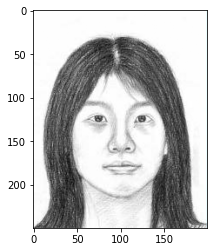

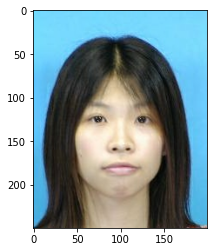

In [48]:
inp, re = load2(path+'/pix2pix/train/concat/0_merged.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [49]:
train_dataset = tf.data.Dataset.list_files(path+'/pix2pix/train/concat/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [50]:
test_dataset = tf.data.Dataset.list_files(path+'/pix2pix/test/concat/*.jpg')
test_dataset = test_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

**Build Generator**

In [51]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(BatchNormalization())
  result.add(LeakyReLU())
  return result

In [52]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result

In [53]:
def Generator():
  inputs = Input(shape=[256,256,3])
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate()([x, skip])
  x = last(x)
  return Model(inputs=inputs, outputs=x)

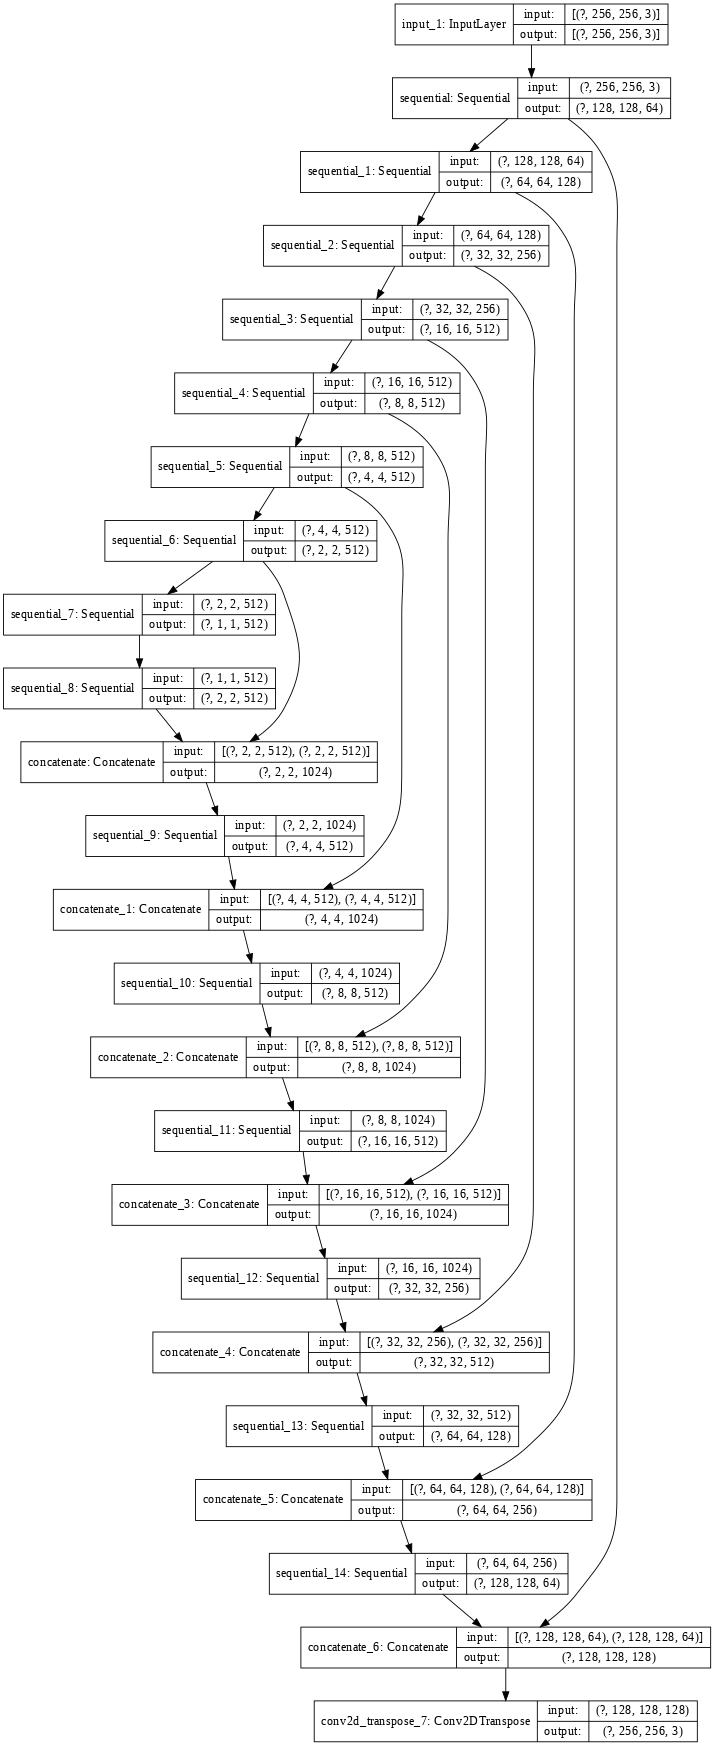

In [54]:
OUTPUT_CHANNELS = 3
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


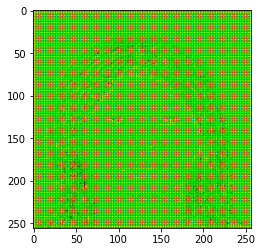

In [55]:
gen_output = generator(rj_inp[tf.newaxis,...])
plt.imshow(gen_output[0,...])

In [56]:
LAMBDA = 100 # it depends on  how our model is perfroming
# we should try with different value to see the result

In [57]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [58]:
def generator_acc(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

**Build Discriminator**

In [59]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = Input(shape=[256, 256, 3], name='input_image')
  tar = Input(shape=[256, 256, 3], name='target_image')

  x = concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = BatchNormalization()(conv)

  leaky_relu = LeakyReLU()(batchnorm1)

  zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return Model(inputs=[inp, tar], outputs=last)

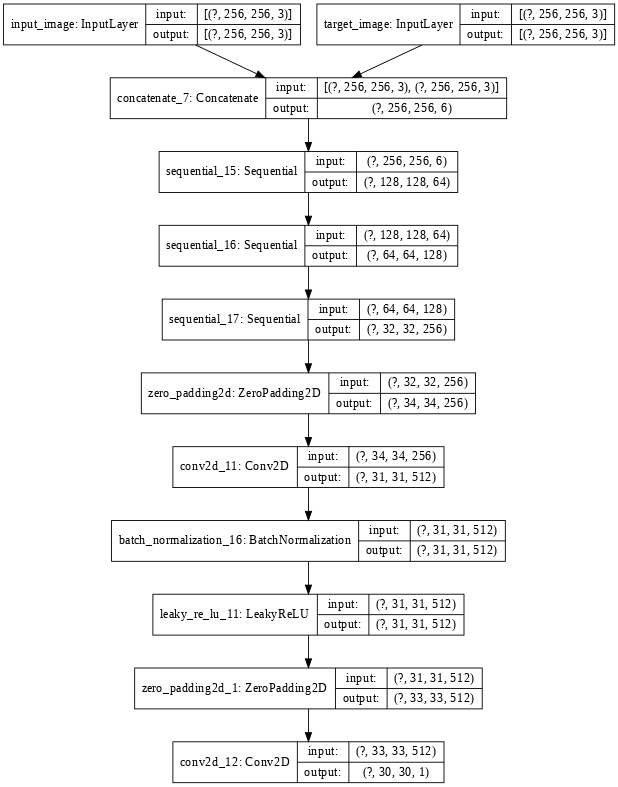

In [60]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

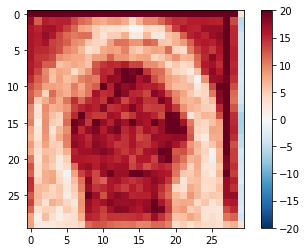

In [61]:
disc_out = discriminator([rj_inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [62]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [63]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [65]:
checkpoint_dir = '/content/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Below function is to see the output of the images from the model

In [66]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  disc_out1 = discriminator([test_input[...], prediction], training=True)
  disc_out2 = discriminator([test_input[...], tar], training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0],disc_out1[0][...,-1],disc_out2[0][...,-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image','Discriminator fake','Discriminator real']

  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

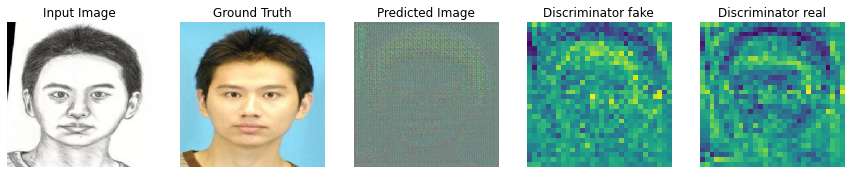

In [67]:
# we predict the image when model is untrained at the begining
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

**Training**

In [73]:
EPOCHS = 10

In [68]:
import datetime
log_dir=path+"/pix2pix/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [69]:
pwd

'/content/dataset'

In [70]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [71]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

#     # saving (checkpoint) the model every  epochs
#     if (epoch + 1) % 20 == 0:
#       checkpoint.save(file_prefix = checkpoint_prefix)

#     print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
#                                                         time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

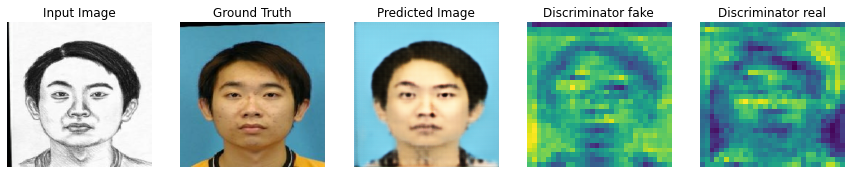

Epoch:  9
........................................................................................


In [74]:
fit(train_dataset, EPOCHS, test_dataset)

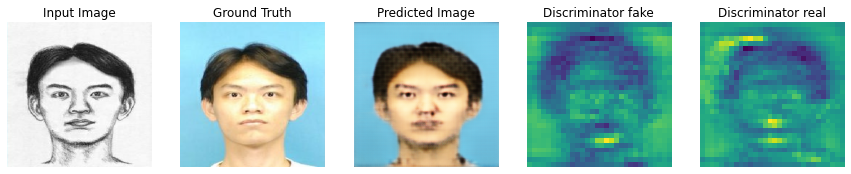

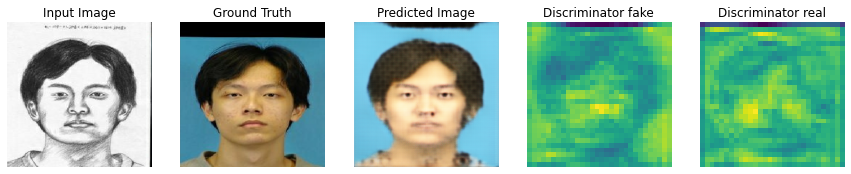

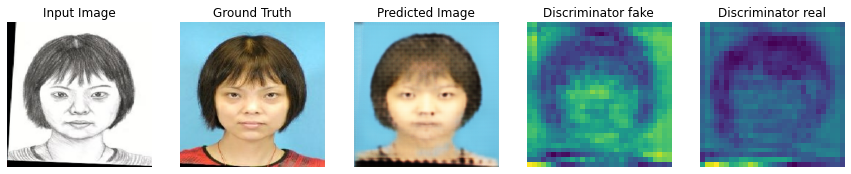

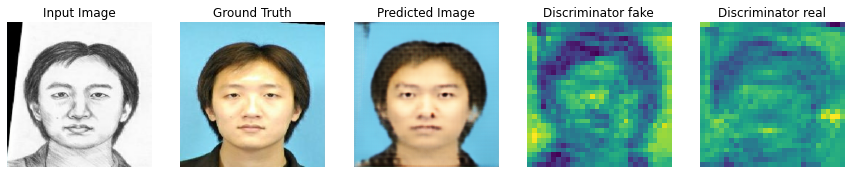

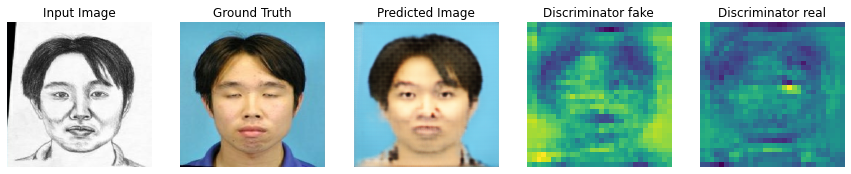

In [75]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [76]:
tf.saved_model.save(generator, path+"/pix2pix/")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/dataset/pix2pix/assets


In [77]:
loaded = tf.saved_model.load(path+"/pix2pix/")
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


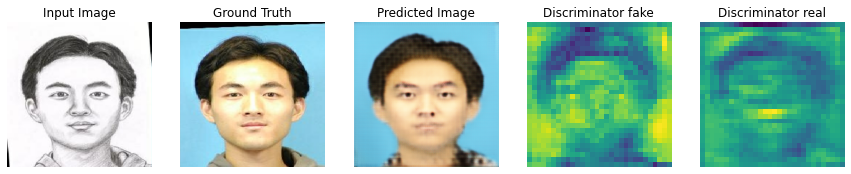

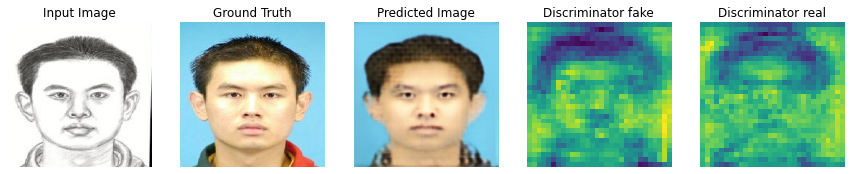

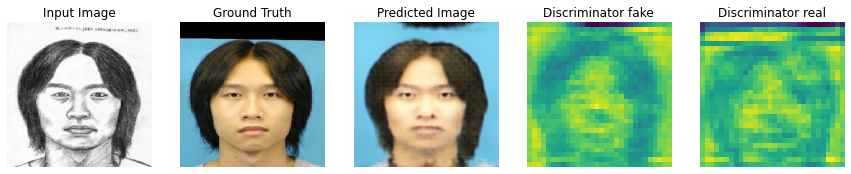

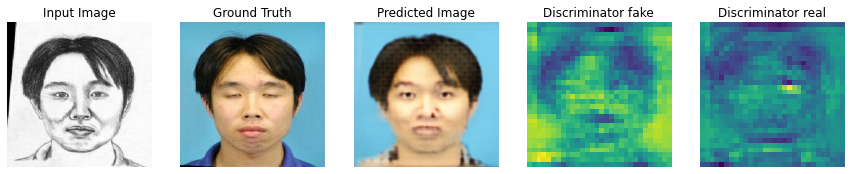

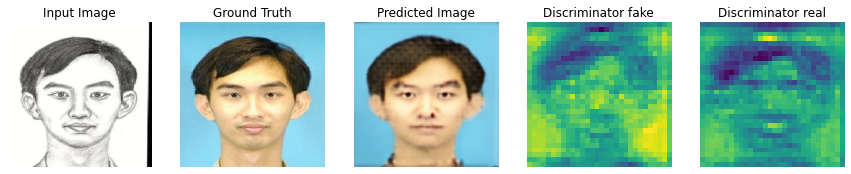

In [78]:
for inp, tar in test_dataset.take(5):
  generate_images(loaded, inp, tar) 